In [3]:
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
import torch
import json
from redi.trajectory import generate_trajectory, save_trajectory, retrieve_nearest_neigbours
from redi.knowledge_base import create_kb
import h5py
import numpy as np

Loading pipeline components...: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
/Users/antonkutsenko/Documents/Nova IMS/Thesis/Diffusion/.venv/lib/python3.12/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:894: FutureWarning: `callback` is deprecated and will be removed in version 1.0.0. Passing `callback` as an inpu

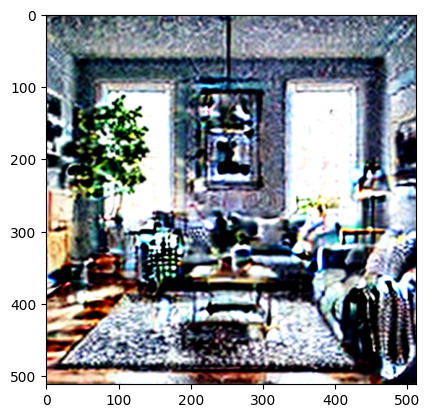

100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


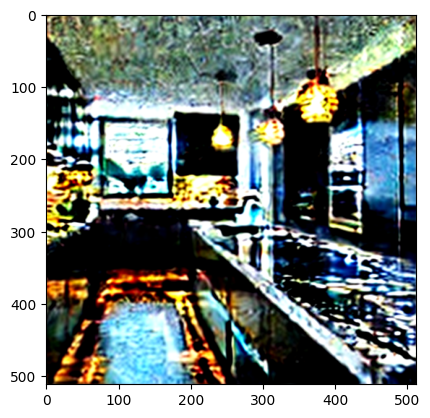

In [ ]:
# pipe = StableDiffusionPipeline.from_pretrained(
#     "stable-diffusion-v1-5/stable-diffusion-v1-5", torch_dtype=torch.float32
# )
pipe = StableDiffusionPipeline.from_pretrained(
    "stabilityai/sd-turbo", torch_dtype=torch.float16
)
EulerDiscreteScheduler.from_config(pipeline.scheduler.config)

json_path = "../data/test_prompts.json"
with open(json_path, "r") as f:
    prompts = json.load(f)["prompts"]

for prompt in prompts[:2]:
    torch.mps.empty_cache()
    generation = generate_trajectory(
        prompt=prompt,
        pipeline=pipe,
        device="mps",
        num_inference_steps=10,
        scheduler=EulerDiscreteScheduler
    )
    save_trajectory(
        trajectory=generation[0],
        prompt=generation[1],
        trajectory_filename="trajectories",
        prompt_filename="prompts",
    )
    del generation

In [29]:
create_kb(
    key_margin_steps=30,
    value_margin_steps=10,
    trajectory_path="../data/generated_data/trajectories.h5",
    kb_path="../data/knowledge_base/knowledge_base.h5",
    faiss_index_path="../data/knowledge_base/faiss_index.bin",

    prompts_from_path="../data/generated_data/prompts.jsonl",
    prompts_to_path="../data/knowledge_base/prompts.json",
    # compression_path="../data/knowledge_base/compression.pkl",
    # key_compression="pca",
    # embedding_dim=30
)

In [25]:
from sklearn.decomposition import PCA
import pickle

#load from piclke file
with open("../data/knowledge_base/compression.pkl", "rb") as f:
    pca = pickle.load(f)

- Ideas to explore - how different are the neigbours with decreasing PCA size
- How differnt are the neighbours if we move key value
- How different are the neighbours if we create more detailed combined keys (like combination of multiple trajectory steps)
- How the quality of generation is affected by the size of KB (if I can have some better size KB)
- Experiment with different schedulers, models (before KB generation)
- Idea of training intermediate model f(key, nearest_neigbours_keys, value) = true value

In [32]:
with h5py.File("../data/generated_data/trajectories.h5", "r") as trajectory_file:
    traj_names = list(trajectory_file.keys())
    query = trajectory_file[traj_names[0]][30]
    # if pca is not None:
    #     query = pca.transform(query.reshape(1, -1)).squeeze()
    neighbours = retrieve_nearest_neigbours(
        query_array=query,
        num_neighbours=5,
        index_path="../data/knowledge_base/faiss_index.bin",
        kb_path="../data/knowledge_base/knowledge_base.h5"
    )

prompts = json.load(open("../data/knowledge_base/prompts.json", "r"))
for neighbour in neighbours:
    print(prompts[neighbour[2]], np.round(neighbour[1],3))


A grand Victorian-style study with mahogany bookshelves and an antique desk. 0.0
A Victorian-era library with rolling ladders and antique wooden bookshelves. 1880.134
A warm and earthy Moroccan lounge with mosaic tiles and low cushioned seating. 1972.327
A rustic mountain cabin with a roaring stone fireplace and wooden beam ceilings. 2075.486
An elegant ballroom-inspired living space with grand chandeliers and marble floors. 2247.253


In [ ]:
A grand Victorian-style study with mahogany bookshelves and an antique desk. 0.0
A Victorian-era library with rolling ladders and antique wooden bookshelves. 24.271
A warm and earthy Moroccan lounge with mosaic tiles and low cushioned seating. 43.516
A gothic-inspired study with dark wood paneling and antique candle sconces. 49.211
A rustic mountain cabin with a roaring stone fireplace and wooden beam ceilings. 56.691

In [ ]:
retrieve_nearest_neigbours(
    
)

In [ ]:


# Open the HDF5 file
with h5py.File("trajectories.h5", "r") as file:
    # # List all groups/datasets in the file
    print("Keys:", list(file.keys()))
    dataset = file["07ef133a"][0].flatten()
    print(dataset.shape, dataset.dtype)


Keys: ['07ef133a', '0c32ea54', '0e2e666f', '13d7f2ea', '16283ea0', '1c789d03', '202e0eaf', '237524db', '26ceacb1', '35f35617', '407c8332', '4302c97e', '43ae4e8e', '44cc92eb', '51e03dee', '52b3598a', '54198dc0', '5a708b5b', '5d27814c', '6481c637', '69006f12', '6d929a2c', '6e488a09', '7e6108a7', '84419dc2', '86659299', '8a474dee', '8c2dbabf', '8eeac974', '9b94ffb7', 'a18a6abc', 'aac09154', 'b3288ef4', 'b6ea3b98', 'b95c8d27', 'bc5b02b7', 'bf0e6924', 'c3769fa9', 'd4bffb93', 'd7380b7b', 'da7ed8f9', 'de655881', 'dfaca00e', 'e1de8d06', 'e2400684', 'e44b6d46', 'edcaedf5', 'ee1b6515', 'f7b2641c', 'f7ff7e37']
(16384,) float32


In [54]:
import faiss
import xxhash
import numpy as np 
D = 1 * 4 * 64 * 64
index = faiss.IndexFlatL2(D)

In [63]:
with h5py.File("trajectories.h5", "r") as trajectory_file:
    traj_names = list(trajectory_file.keys())
    D, I = index.search(trajectory_file[traj_names[0]][10].reshape(1, -1), 3)

In [67]:
I[0]

array([ 0, 50, 24])

In [52]:
index.add(flat_key)

In [57]:
import faiss

def save_faiss_incrementally(index, filename="faiss_index.bin"):
    """Save FAISS index incrementally without overwriting existing data"""
    faiss.write_index(index, filename)  # Overwrites but keeps all existing entries


In [ ]:
key = 10
value = 10

with h5py.File("trajectories.h5", "r") as trajectory_file:
        traj_names = list(trajectory_file.keys())
        with h5py.File(f"{"new"}.h5", "a") as kb_file:
            for name in traj_names:
                flat_key = trajectory_file[name][key].reshape(1, -1)
                index.add(flat_key)
                kb_file.create_dataset((index.ntotal-1).to_bytes(), 
                                data=trajectory_file[name][-value].flatten(), 
                                compression="gzip", 
                                compression_opts=4)
                faiss.write_index(index, "faiss_index.bin")

In [21]:
import faiss
import lmdb
import numpy as np

# Set FAISS index dimension (1×4×64×64 = 16384)
D = 1 * 4 * 64 * 64

# Create FAISS L2 index
index = faiss.IndexFlatL2(D)  # L2 distance search

# Initialize LMDB
db = lmdb.open("faiss_lmdb", map_size=10**9, max_key_size=16384)  # 1GB max size (adjust as needed)


TypeError: unrecognized keyword argument

In [20]:
# Generate random sample data
num_samples = 1000  # Adjust as needed
keys = np.random.rand(num_samples, 1, 4, 64, 64).astype(np.float32)  # Shape (N, 1, 4, 64, 64)
values = np.random.rand(num_samples, 1, 4, 64, 64).astype(np.float32)  # Shape (N, 1, 4, 64, 64)

# Reshape keys for FAISS (FAISS needs 2D shape: (N, D))
keys_flat = keys.reshape(num_samples, -1)  # (N, 16384)
values_flat = values.reshape(num_samples, -1)  # (N, 16384)

# Add keys to FAISS
index.add(keys_flat)  # Add all keys to FAISS index

# Store in LMDB
with db.begin(write=True) as txn:
    for i in range(num_samples):
        txn.put(keys_flat[i].tobytes(), values_flat[i].tobytes())  # Store serialized arrays

print("✅ FAISS Index & LMDB Storage Complete!")


BadValsizeError: mdb_put: MDB_BAD_VALSIZE: Unsupported size of key/DB name/data, or wrong DUPFIXED size

In [ ]:
k = 
dataset[0].shape

(1, 4, 64, 64)

In [ ]:
import faiss
import rocksdb
import numpy as np

In [ ]:
db = rocksdb.DB("faiss_rocksdb", rocksdb.Options(create_if_missing=True))

In [ ]:
def retrieve_nearest(query_array):
    """Retrieve the closest stored array using FAISS + LMDB"""
    query_flat = query_array.reshape(1, -1).astype(np.float32)  # Ensure correct shape

    # Search FAISS for the closest match
    D, I = index.search(query_flat, 1)  # Find 1 nearest neighbor
    nearest_key = keys_flat[I[0][0]]  # Retrieve the best matching key

    # Fetch the corresponding value from LMDB
    with db.begin() as txn:
        value_bytes = txn.get(nearest_key.tobytes())  # Retrieve raw bytes
        if value_bytes:
            retrieved_value = np.frombuffer(value_bytes, dtype=np.float32).reshape(1, 4, 64, 64)  # Zero-copy conversion
            return retrieved_value
    return None

# Test with a random query
query = np.random.rand(1, 4, 64, 64).astype(np.float32)
retrieved_value = retrieve_nearest(query)

print("✅ Retrieved Value Shape:", retrieved_value.shape)
